In [1]:
#############
###paths#####
#############
import sys
import os

from importlib_metadata import distribution
pwd = os.getcwd()
modellingpath = pwd.rpartition("modelling")[0] + pwd.rpartition("modelling")[1] 
sys.path.append(modellingpath + '/lib')
#############

from numerical.cn_plot import plot1D, surfpattern
from numerical.countPeaksAnalysisFunctions import countPeaks, varPeakDistFunction
from numerical.generalFunctions import round_it

from analytical.linear_stability_analysis import detailed_turing_analysis_dict
from randomfunctions import plot_all_dispersion

from scipy.signal import find_peaks
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm



Longer runs with record and variant2

In [2]:

circuit_n='turinghill'
variant= 2
n_species=2
mechanism='nogrowth'
L=50; x_gridpoints=5; J=L*x_gridpoints;I=J 
T=5000; t_gridpoints = 30; N=T*t_gridpoints #Number of timepoints
filename= lambda parID: '%s_variant%s_%s_ID%s_L%r_J%r_T%r_N%r'%(circuit_n,variant,mechanism,parID,L,J,T,N)
n_param_sets=100000
lsa_df= pickle.load( open(modellingpath + '/growth/out/analytical/lsa_dataframes/lsa_df_%s_variant%r_%rparametersets.pkl'%(circuit_n,variant,n_param_sets), "rb"))
single_lsa_df =  lsa_df.xs(0, level=1)


In [3]:
metric='psEntropy'
df = pickle.load( open( modellingpath + '/growth/out/patternAnalysis/%s/%s/%s/%s_df_%s.pkl'%(circuit_n,mechanism,metric,metric,filename('x')), 'rb'))
print(df['system_class'].value_counts())
states = ['turing I, turing II', 'turing I hopf', 'turing I oscillatory', 'turing II hopf','hopf', 'complex unstable', 'turing semi-hopf']  
special_df = df.loc[df['system_class'].isin(states)]
special_df


simple stable           99707
simple unstable             6
complex unstable            4
hopf                        2
turing I oscillatory        1
Name: system_class, dtype: int64


,ba,bb,Va,Vb,kaa,kba,kab,kbb,mua,mub,n,d_B,d_A,ss_n,ss_list,ss_class,system_class,maxeig,psEntropy
11762,0.545095,2.971929,85.198011,8.650211,95.739387,11.074479,90.786025,29.89886,0.187928,0.806901,3.97552,0.212428,1.0,3.0,"[20.891703702092, 4.222283408261904]",unstable point,complex unstable,0.112287+0.000000j,5.517453
16078,0.3631,3.323762,43.450914,4.809304,3.630614,18.979012,2.249361,0.147177,0.866578,0.103194,2.603938,0.004551,1.0,1.0,"[1.367322215786549, 44.783427326952115]",unstable spiral,hopf,0.041471+0.148966j,5.517453
27913,0.106242,3.724017,61.367413,1.278761,20.622766,77.101104,1.702859,2.249755,0.304152,0.654506,2.910394,0.012087,1.0,3.0,"[1.6982817825175744, 6.664071789054602]",unstable point,complex unstable,0.175367+0.000000j,5.517453
32095,0.111941,0.336638,7.982727,1.325088,4.205581,2.91428,2.039945,6.805688,0.345747,0.231436,2.968789,8.59344,1.0,1.0,"[1.144938602601918, 2.826103092813921]",stable spiral,turing I oscillatory,0.004540+0.000000j,0.710187
36335,0.389568,0.146191,91.403926,14.230039,50.139376,10.09229,89.419338,0.107876,0.089886,0.016665,2.721816,0.324604,1.0,1.0,"[12.576744225489556, 25.336680324136633]",unstable spiral,hopf,0.002149+0.042648j,5.517453
46199,0.309051,0.325186,26.415923,26.891388,13.482234,59.850451,0.131579,0.733183,0.487044,0.890724,2.385701,0.698531,1.0,3.0,"[3.795792575310859, 30.519325625777874]",unstable point,complex unstable,0.264340+0.000000j,5.517453
74016,0.762034,0.489399,67.908713,0.477107,91.681208,6.64399,0.876766,42.657362,0.179302,0.405422,3.828228,0.029257,1.0,3.0,"[21.038655222765023, 2.381911959443281]",unstable point,complex unstable,0.092500+0.000000j,5.517453


In [7]:
def parID_display(parID, L,J,T,round=False,crop=100,ss_n=0,single_lsa_df = single_lsa_df):
    #data
    U = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Dfinal_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))
    
    #plot
    plot1D(U,round=round)
    plt.show()

    #dispersion
    par_dict = single_lsa_df.loc[parID].to_dict() #converts a dataframe row into a dictionary outputing a dictionary for a specific parameter set
    out = detailed_turing_analysis_dict(par_dict, circuit_n, n_species)
    plot_all_dispersion(out[-2][ss_n],2, crop=crop)
    print(out[3])
    plt.show()

    #convergence
    parID_surfpattern(parID,L,J,T)

def parID_surfpattern(parID,L,J,T,record_every_x_hours = 10):
    #data 
    U_record = pickle.load( open(modellingpath + '/growth/out/numerical/%s/%s/data/2Drecord_%s.pkl'%(circuit_n,mechanism,filename(parID)), 'rb'))
    
    #grids
    dx = float(L)/float(J-1)
    x_grid = np.array([j*dx for j in range(J)])
    reduced_t_grid = np.arange(0,T,record_every_x_hours) 

    #plot
    surfpattern(U_record, [x_grid, reduced_t_grid], 'linear',  morphogen=0, rate=0, savefig=False,filename='',logResults=False,normalize=False)


3524.6084236453153 3524.6084236451884


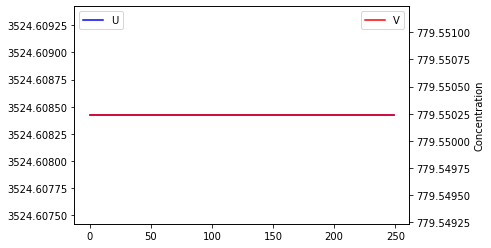

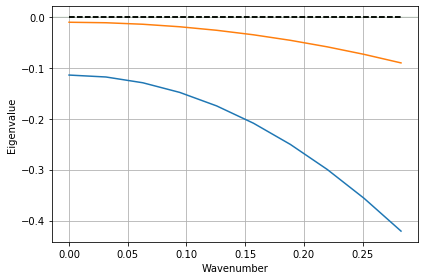

['simple stable']


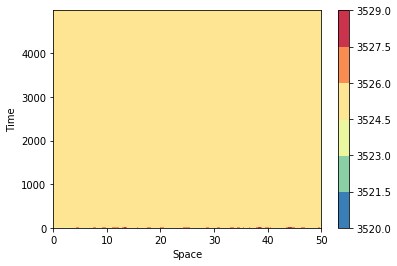

In [8]:

parID_display(1,L,J,T,crop=10)


159.20839626241946 159.20839626241343


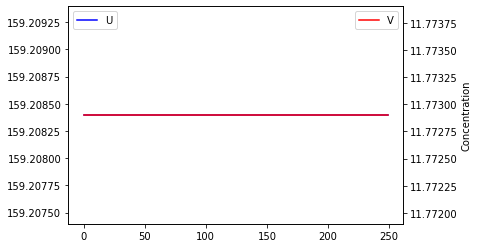

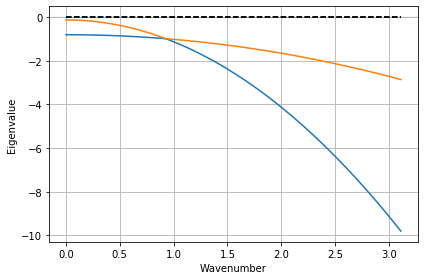

['simple stable', 'simple stable', 'complex unstable']


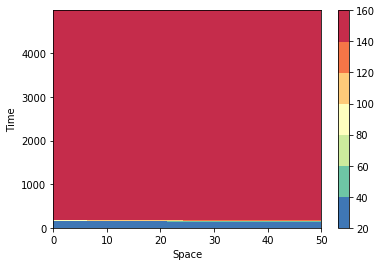

--------------------------------------
0.8701019821952245 0.8701001947762951


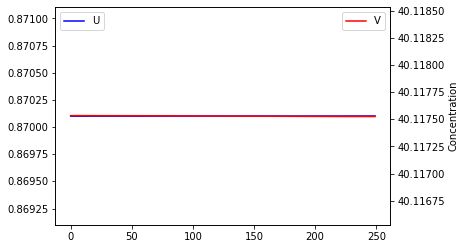

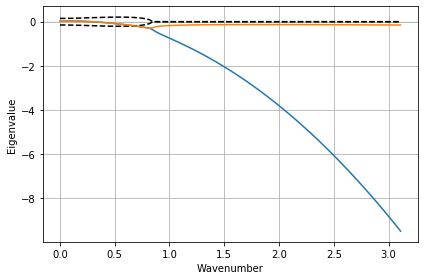

['hopf']


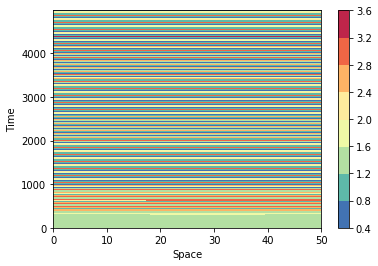

--------------------------------------
198.00693719856596 198.00693719855906


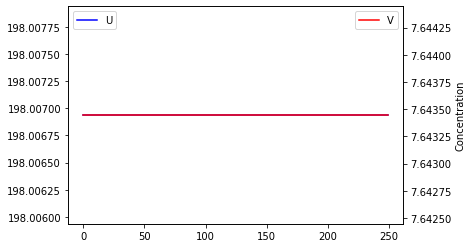

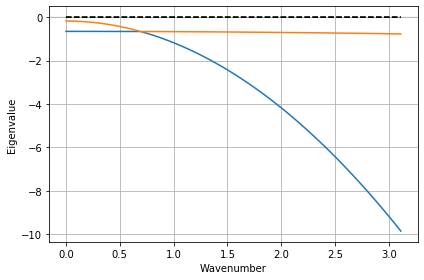

['simple stable', 'simple stable', 'complex unstable']


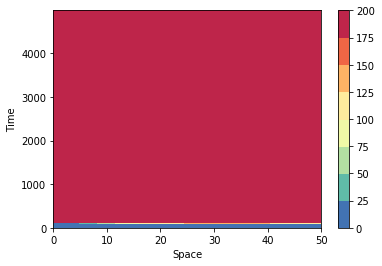

--------------------------------------
1.3790902568835355 0.9480944923608958


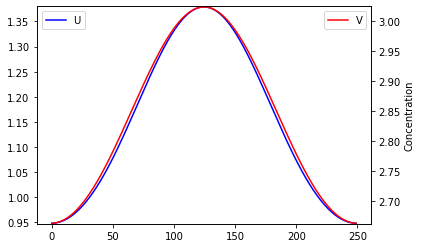

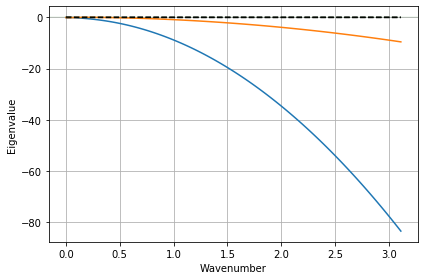

['turing I oscillatory']


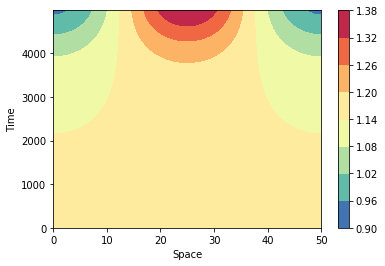

--------------------------------------
12.827874087473225 12.827873697451452


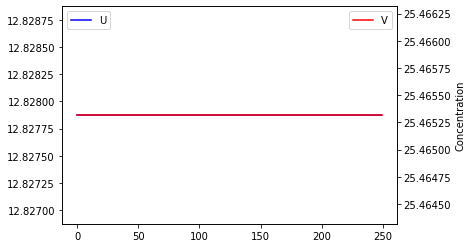

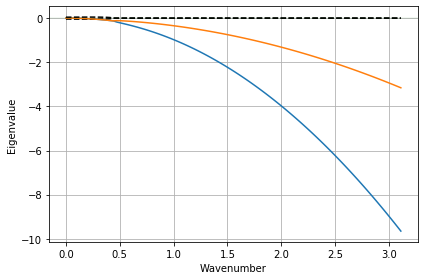

['hopf']


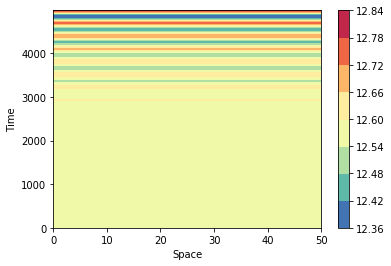

--------------------------------------
39.08278451791915 39.082784517918014


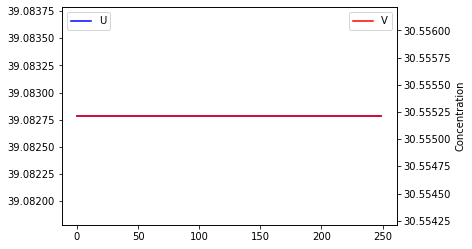

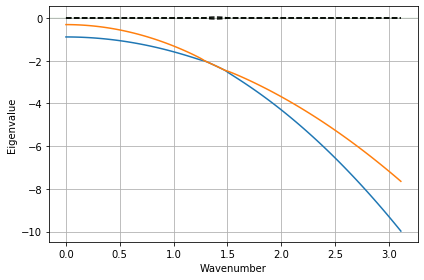

['simple stable', 'simple stable', 'complex unstable']


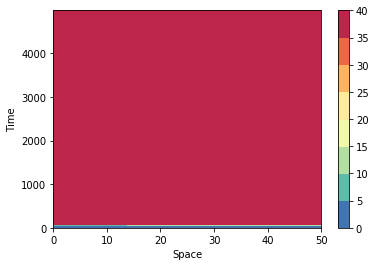

--------------------------------------
313.3272698108825 313.32726981087353


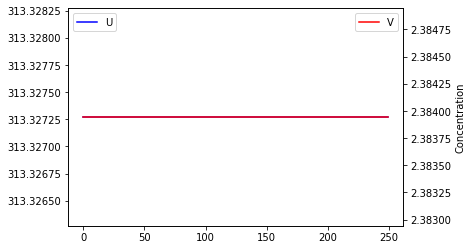

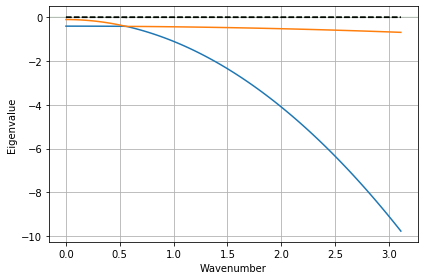

['simple stable', 'simple stable', 'complex unstable']


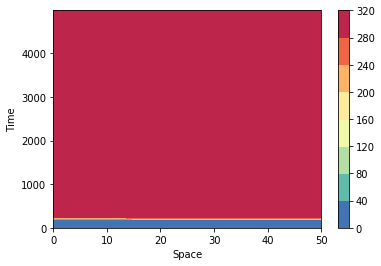

--------------------------------------


In [10]:
for parID in special_df.index:
    parID_display(parID,L,J,T)
    print('--------------------------------------')

In [4]:

circuit_n='turinghill'
variant= 0
n_species=2
mechanism='nogrowth'
L=50; x_gridpoints=5; J=L*x_gridpoints;I=J 
T=2000; t_gridpoints = 25; N=T*t_gridpoints #Number of timepoints
filename= lambda parID: '%s_variant%s_%s_ID%s_L%r_J%r_T%r_N%r'%(circuit_n,variant,mechanism,parID,L,J,T,N)
n_param_sets=100000
lsa_df= pickle.load( open(modellingpath + '/growth/out/analytical/lsa_dataframes/lsa_df_%s_variant%r_%rparametersets.pkl'%(circuit_n,variant,n_param_sets), "rb"))
single_lsa_df =  lsa_df.xs(0, level=1)


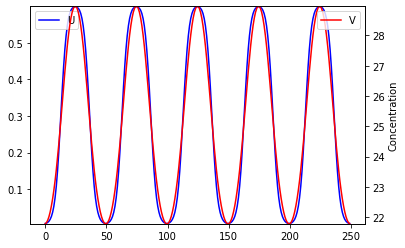

{'ba': 0.01, 'bb': 0.01, 'Va': 60.908616151088026, 'Vb': 851.6367407297504, 'kaa': 0.6216228388440519, 'kba': 13.397284319804438, 'kab': 2.6479240460564557, 'kbb': 80.73356904307079, 'mua': 8.538398200076283, 'mub': 0.6427834916927492, 'd_B': 7.195872708771351, 'd_A': 1.0, 'n': 2.0, 'ss_n': 3.0, 'ss_list': array([0.05346665, 0.55552064]), 'ss_class': 'unstable point', 'system_class': 'simple unstable', 'maxeig': (8.037668795697549+0j)}
{'ba': 0.01, 'bb': 0.01, 'Va': 60.908616151088026, 'Vb': 851.6367407297504, 'kaa': 0.6216228388440519, 'kba': 13.397284319804438, 'kab': 2.6479240460564557, 'kbb': 80.73356904307079, 'mua': 8.538398200076283, 'mub': 0.6427834916927492, 'd_B': 7.195872708771351, 'd_A': 1.0, 'n': 2.0, 'ss_n': 3.0, 'ss_list': array([0.05346665, 0.55552064]), 'ss_class': 'unstable point', 'system_class': 'simple unstable', 'maxeig': (8.037668795697549+0j)}


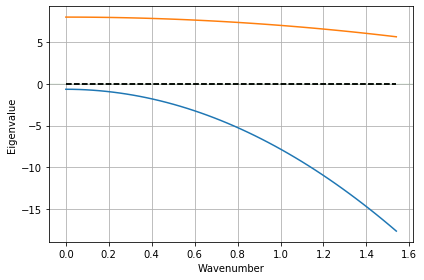

['simple stable', 'turing I hopf', 'simple unstable']


In [7]:

parID_display(41018, ss_n=2,crop=50)


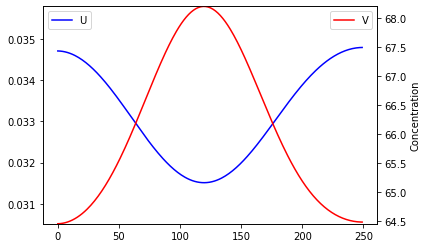

{'ba': 0.01, 'bb': 0.01, 'Va': 75.66160422908123, 'Vb': 298.428175756802, 'kaa': 1.8418366241514912, 'kba': 38.573580359421754, 'kab': 37.32848128016661, 'kbb': 0.7468403166433579, 'mua': 0.48706162605455466, 'mub': 0.00148667574399458, 'd_B': 0.00783622273021035, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([  1.27681512, 241.30536998]), 'ss_class': 'unstable point', 'system_class': 'simple unstable', 'maxeig': (0.1414455411025985+0j)}
{'ba': 0.01, 'bb': 0.01, 'Va': 75.66160422908123, 'Vb': 298.428175756802, 'kaa': 1.8418366241514912, 'kba': 38.573580359421754, 'kab': 37.32848128016661, 'kbb': 0.7468403166433579, 'mua': 0.48706162605455466, 'mub': 0.00148667574399458, 'd_B': 0.00783622273021035, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([  1.27681512, 241.30536998]), 'ss_class': 'unstable point', 'system_class': 'simple unstable', 'maxeig': (0.1414455411025985+0j)}


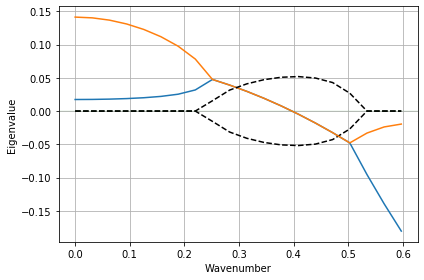

['hopf']


In [8]:

parID_display(3676, crop=20)

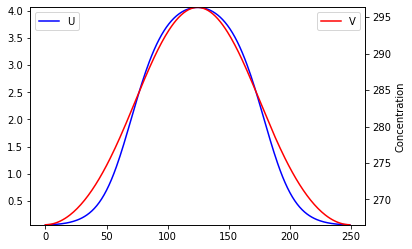

{'ba': 0.01, 'bb': 0.01, 'Va': 48.352946451621094, 'Vb': 30.09839037763468, 'kaa': 3.4589945017851766, 'kba': 66.98419135130355, 'kab': 7.92557297354157, 'kbb': 0.20671233306271183, 'mua': 0.3283592238357517, 'mub': 0.007437796060241441, 'd_B': 6.804641861326742, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([  2.18907215, 288.17733277]), 'ss_class': 'unstable spiral', 'system_class': 'hopf', 'maxeig': (0.07568749844757547+0j)}
{'ba': 0.01, 'bb': 0.01, 'Va': 48.352946451621094, 'Vb': 30.09839037763468, 'kaa': 3.4589945017851766, 'kba': 66.98419135130355, 'kab': 7.92557297354157, 'kbb': 0.20671233306271183, 'mua': 0.3283592238357517, 'mub': 0.007437796060241441, 'd_B': 6.804641861326742, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([  2.18907215, 288.17733277]), 'ss_class': 'unstable spiral', 'system_class': 'hopf', 'maxeig': (0.07568749844757547+0j)}


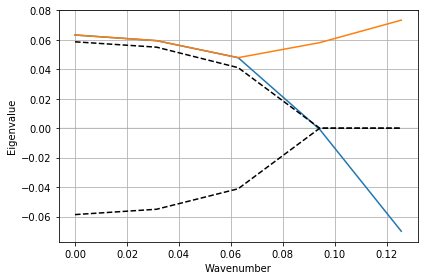

['complex unstable']


In [9]:

parID_display(16261, crop=5)


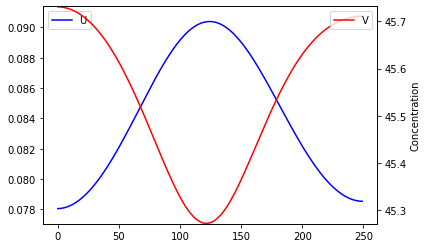

{'ba': 0.01, 'bb': 0.01, 'Va': 13.708684894397337, 'Vb': 20.652741331171868, 'kaa': 1.2062363010467874, 'kba': 6.912381569286334, 'kab': 7.641020164512173, 'kbb': 8.192059662122727, 'mua': 0.26306122790942016, 'mub': 0.0017659734645798502, 'd_B': 0.011888145768114802, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([ 0.28644104, 22.07381874]), 'ss_class': 'unstable point', 'system_class': 'simple unstable', 'maxeig': (0.16223184124150533+0j)}
{'ba': 0.01, 'bb': 0.01, 'Va': 13.708684894397337, 'Vb': 20.652741331171868, 'kaa': 1.2062363010467874, 'kba': 6.912381569286334, 'kab': 7.641020164512173, 'kbb': 8.192059662122727, 'mua': 0.26306122790942016, 'mub': 0.0017659734645798502, 'd_B': 0.011888145768114802, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([ 0.28644104, 22.07381874]), 'ss_class': 'unstable point', 'system_class': 'simple unstable', 'maxeig': (0.16223184124150533+0j)}


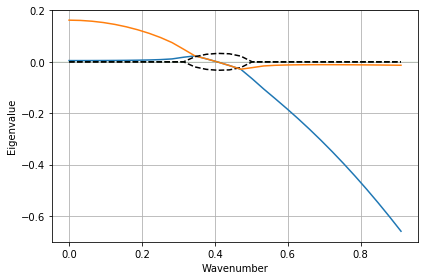

['hopf']


In [10]:

parID_display(323,crop=30)


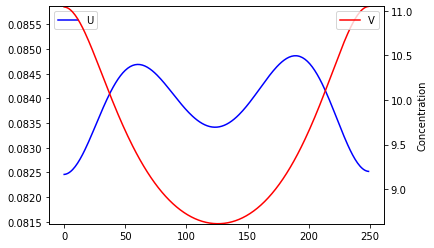

{'ba': 0.01, 'bb': 0.01, 'Va': 44.331872752219624, 'Vb': 338.26877993225685, 'kaa': 3.3547562718963126, 'kba': 7.9250572824794725, 'kab': 8.448163351187658, 'kbb': 0.16329631970276404, 'mua': 0.30597918705155724, 'mub': 0.19053403687713216, 'd_B': 0.030463817799161217, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([ 1.05138991, 27.13034674]), 'ss_class': 'unstable spiral', 'system_class': 'hopf', 'maxeig': (0.021710671288953966+0.399471626130244j)}
{'ba': 0.01, 'bb': 0.01, 'Va': 44.331872752219624, 'Vb': 338.26877993225685, 'kaa': 3.3547562718963126, 'kba': 7.9250572824794725, 'kab': 8.448163351187658, 'kbb': 0.16329631970276404, 'mua': 0.30597918705155724, 'mub': 0.19053403687713216, 'd_B': 0.030463817799161217, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([ 1.05138991, 27.13034674]), 'ss_class': 'unstable spiral', 'system_class': 'hopf', 'maxeig': (0.021710671288953966+0.399471626130244j)}


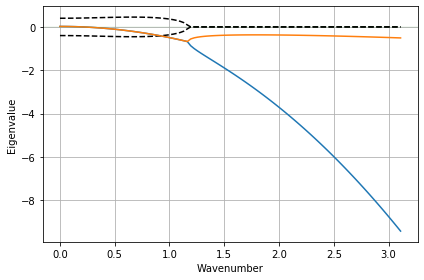

['hopf']


In [11]:
parID_display(18689)


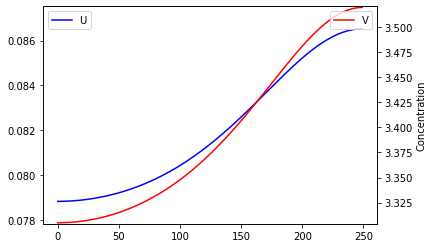

{'ba': 0.01, 'bb': 0.01, 'Va': 179.80390659800986, 'Vb': 35.792033163975255, 'kaa': 0.7659717663686151, 'kba': 0.15531598145168207, 'kab': 1.7122989871743242, 'kbb': 0.7553167555115491, 'mua': 0.5038257967420267, 'mub': 0.24122990388919446, 'd_B': 0.034349767325531945, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([0.1804841 , 1.67178342]), 'ss_class': 'unstable spiral', 'system_class': 'hopf', 'maxeig': (0.05230604993330925+0.5723547675454909j)}
{'ba': 0.01, 'bb': 0.01, 'Va': 179.80390659800986, 'Vb': 35.792033163975255, 'kaa': 0.7659717663686151, 'kba': 0.15531598145168207, 'kab': 1.7122989871743242, 'kbb': 0.7553167555115491, 'mua': 0.5038257967420267, 'mub': 0.24122990388919446, 'd_B': 0.034349767325531945, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([0.1804841 , 1.67178342]), 'ss_class': 'unstable spiral', 'system_class': 'hopf', 'maxeig': (0.05230604993330925+0.5723547675454909j)}


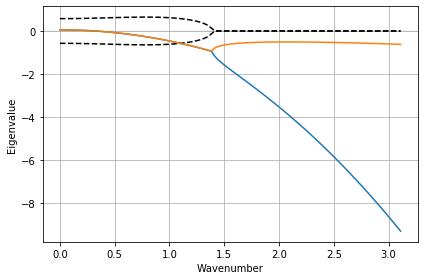

['hopf']


In [12]:

parID_display(3580)


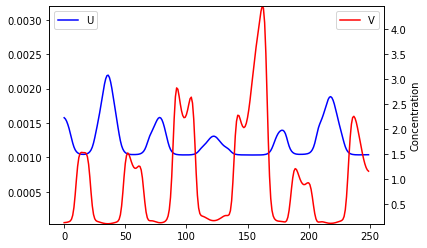

{'ba': 0.01, 'bb': 0.01, 'Va': 292.88332892452263, 'Vb': 486.2531630773667, 'kaa': 0.21054696394962158, 'kba': 0.11078167142612357, 'kab': 0.30131863629801214, 'kbb': 9.979862701814936, 'mua': 9.671290181233479, 'mub': 1.0267473684945412, 'd_B': 0.005259257236402405, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([0.00648062, 0.22870692]), 'ss_class': 'unstable spiral', 'system_class': 'hopf', 'maxeig': (2.7724126985172575+3.382959861239213j)}


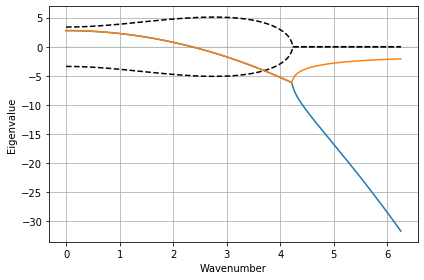

In [28]:

parID_display( 28817,crop=200)


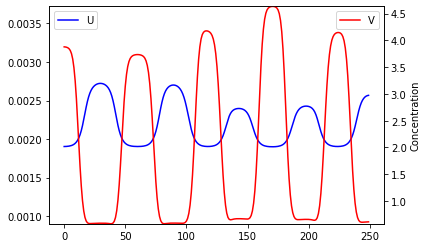

{'ba': 0.01, 'bb': 0.01, 'Va': 887.3976810634131, 'Vb': 621.5082654325614, 'kaa': 0.21239643530338062, 'kba': 0.11104906542778901, 'kab': 1.6551470970511883, 'kbb': 0.9597257152142981, 'mua': 5.293891273660762, 'mub': 0.17398259803013874, 'd_B': 0.0014465561532232226, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([0.02938385, 1.1829765 ]), 'ss_class': 'unstable point', 'system_class': 'simple unstable', 'maxeig': (3.5570492866984096+0j)}


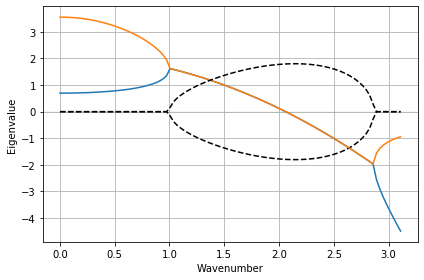

In [29]:

parID = 9387
parID_display(parID)

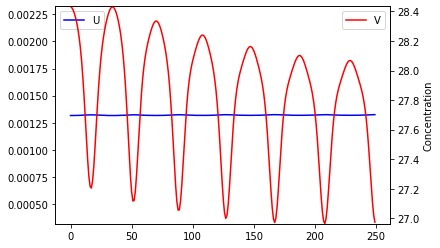

{'ba': 0.01, 'bb': 0.01, 'Va': 369.1991570889651, 'Vb': 458.8674578679268, 'kaa': 0.10196208532515735, 'kba': 2.9546586728237396, 'kab': 0.1306507890248125, 'kbb': 1.5341527655160627, 'mua': 8.087859165059683, 'mub': 0.09622428847743275, 'd_B': 0.005054076054457198, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([8.23695741e-03, 1.89833612e+01]), 'ss_class': 'unstable point', 'system_class': 'simple unstable', 'maxeig': (5.075904477058194+0j)}


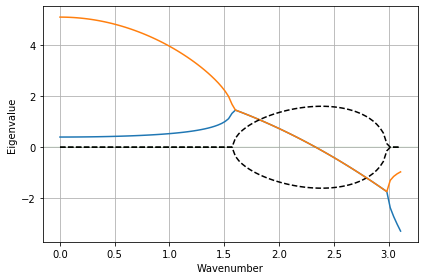

In [30]:


parID = 4162
parID_display(parID)

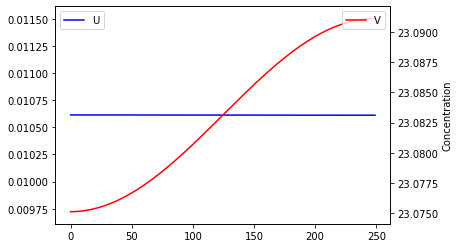

{'ba': 0.01, 'bb': 0.01, 'Va': 438.40056843430835, 'Vb': 692.9102987537758, 'kaa': 1.2091998752650004, 'kba': 5.098276261536887, 'kab': 6.259819631455006, 'kbb': 23.576510622180955, 'mua': 1.0896583057901446, 'mub': 0.002237384270207853, 'd_B': 0.5574016210421167, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([ 0.04304571, 19.09723836]), 'ss_class': 'unstable point', 'system_class': 'simple unstable', 'maxeig': (0.6143704066450918+0j)}
{'ba': 0.01, 'bb': 0.01, 'Va': 438.40056843430835, 'Vb': 692.9102987537758, 'kaa': 1.2091998752650004, 'kba': 5.098276261536887, 'kab': 6.259819631455006, 'kbb': 23.576510622180955, 'mua': 1.0896583057901446, 'mub': 0.002237384270207853, 'd_B': 0.5574016210421167, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([ 0.04304571, 19.09723836]), 'ss_class': 'unstable point', 'system_class': 'simple unstable', 'maxeig': (0.6143704066450918+0j)}


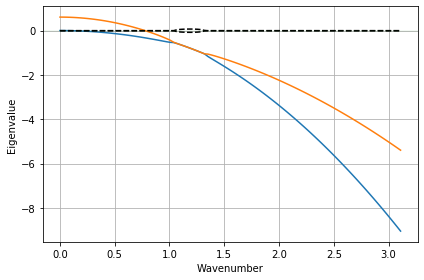

['complex unstable']


In [17]:


parID = 2
parID_display(parID)

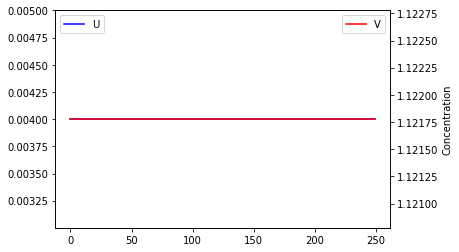

{'ba': 0.01, 'bb': 0.01, 'Va': 10.4723895110599, 'Vb': 58.697952397154026, 'kaa': 15.774821326567553, 'kba': 2.477511247656896, 'kab': 0.24633952879295773, 'kbb': 0.712156459705568, 'mua': 2.499641540488128, 'mub': 0.022712754839464562, 'd_B': 0.0013222814476554904, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([0.00400057, 1.12170073]), 'ss_class': 'stable point', 'system_class': 'simple stable', 'maxeig': (-0.022713284365283845+0j)}
{'ba': 0.01, 'bb': 0.01, 'Va': 10.4723895110599, 'Vb': 58.697952397154026, 'kaa': 15.774821326567553, 'kba': 2.477511247656896, 'kab': 0.24633952879295773, 'kbb': 0.712156459705568, 'mua': 2.499641540488128, 'mub': 0.022712754839464562, 'd_B': 0.0013222814476554904, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([0.00400057, 1.12170073]), 'ss_class': 'stable point', 'system_class': 'simple stable', 'maxeig': (-0.022713284365283845+0j)}


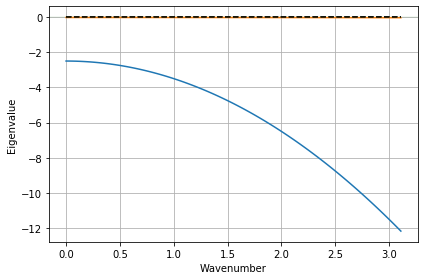

['simple stable']


In [16]:


parID = 3
parID_display(parID)

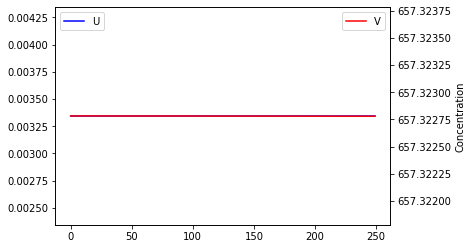

{'ba': 0.01, 'bb': 0.01, 'Va': 976.6940772656541, 'Vb': 19.470199509907232, 'kaa': 0.6666351221355362, 'kba': 169.34055476467992, 'kab': 0.24605936651512714, 'kbb': 2.526810115983707, 'mua': 3.4472621753995294, 'mub': 0.004196462130167872, 'd_B': 1.8688856916463181, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([1.98497000e-01, 1.83144481e+03]), 'ss_class': 'unstable point', 'system_class': 'simple unstable', 'maxeig': (2.780938248364859+0j)}
{'ba': 0.01, 'bb': 0.01, 'Va': 976.6940772656541, 'Vb': 19.470199509907232, 'kaa': 0.6666351221355362, 'kba': 169.34055476467992, 'kab': 0.24605936651512714, 'kbb': 2.526810115983707, 'mua': 3.4472621753995294, 'mub': 0.004196462130167872, 'd_B': 1.8688856916463181, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([1.98497000e-01, 1.83144481e+03]), 'ss_class': 'unstable point', 'system_class': 'simple unstable', 'maxeig': (2.780938248364859+0j)}


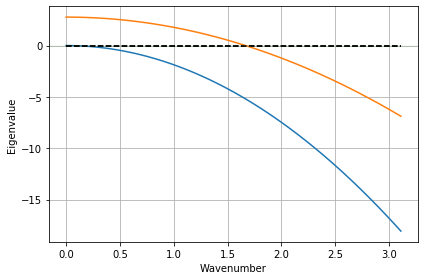

['simple unstable']


In [15]:


parID = 99895
parID_display(parID)

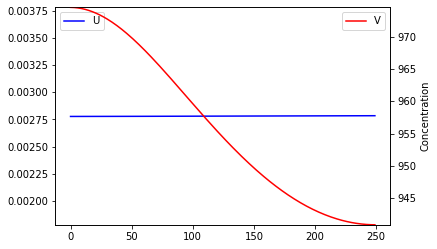

{'ba': 0.01, 'bb': 0.01, 'Va': 176.32369633814233, 'Vb': 508.29817091472154, 'kaa': 0.2627082477509633, 'kba': 133.78030127622253, 'kab': 0.326362023219531, 'kbb': 70.4552682913608, 'mua': 3.724884590321072, 'mub': 0.10057068887353435, 'd_B': 0.0023087090172238495, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([1.85528121e-01, 1.23449505e+03]), 'ss_class': 'unstable spiral', 'system_class': 'hopf', 'maxeig': (0.5366567685988974+0.8348603439286305j)}
{'ba': 0.01, 'bb': 0.01, 'Va': 176.32369633814233, 'Vb': 508.29817091472154, 'kaa': 0.2627082477509633, 'kba': 133.78030127622253, 'kab': 0.326362023219531, 'kbb': 70.4552682913608, 'mua': 3.724884590321072, 'mub': 0.10057068887353435, 'd_B': 0.0023087090172238495, 'd_A': 1.0, 'n': 2.0, 'ss_n': 1.0, 'ss_list': array([1.85528121e-01, 1.23449505e+03]), 'ss_class': 'unstable spiral', 'system_class': 'hopf', 'maxeig': (0.5366567685988974+0.8348603439286305j)}


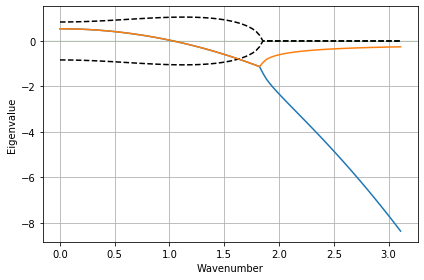

['hopf']


In [13]:
parID = 12464
parID_display(parID)